# NN 다중분류(흑백)
- MNIST 데이터셋
* 사람 손 글씨(0~9)
* 흑백 이미지 - 28*28 픽셀
* 읽기 편하도록 만들어진 라이브러리 파일(npz) - 다운로드 받아서 사용

In [ ]:
!pip install --q ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.2 MB/s eta 0:00:00
time: 442 µs (started: 2024-07-01 01:33:56 +00:00)


## 1. 데이터 준비

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras

time: 28.9 s (started: 2024-07-01 01:33:56 +00:00)


## 1. 데이터 준비

In [ ]:
# MNIST 데이터 다운로드
# npz - 중간단계가 어느정도 거쳐져서 numpy로 저장된 파일
#!wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz

--2024-07-01 01:34:25--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.207, 173.194.217.207, 74.125.26.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10.96M  --.-KB/s    in 0.1s    

2024-07-01 01:34:26 (80.8 MB/s) - ‘mnist.npz’ saved [11490434/11490434]

time: 350 ms (started: 2024-07-01 01:34:25 +00:00)


In [ ]:
mnist = np.load('mnist.npz')
mnist
# keys: x_test, x_train, y_train, y_test
# 전처리가 완료돼서 4개 데이터로 나눠져서 저장이 됨

NpzFile 'mnist.npz' with keys: x_test, x_train, y_train, y_test

time: 33.5 ms (started: 2024-07-01 01:34:26 +00:00)


In [ ]:
# X값은 스케일링 후 모델에 집어넣을 것
X_train = mnist['x_train']
X_test = mnist['x_test']
y_train = mnist['y_train']
y_test = mnist['y_test']

time: 455 ms (started: 2024-07-01 01:34:26 +00:00)


In [ ]:
# 흑백이어서 채널이 없음
print(X_train.shape, X_test.shape)
print(type(X_train), type(X_test))
print(y_train.shape, y_test.shape)
print(type(y_train), type(y_test))

(60000, 28, 28) (10000, 28, 28)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(60000,) (10000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
time: 1.08 ms (started: 2024-07-01 01:34:26 +00:00)


## 2. 데이터 확인

In [ ]:
# NN에 넣을 때는 y값을 one-hot encoding하고 넣음
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

time: 5.59 ms (started: 2024-07-01 01:34:26 +00:00)


In [ ]:
np.random.seed(42)
# 할때마다 다른 게 뽑힐 것
sample = np.random.randint(60000, size = 25) # 범위를 주고 이에서 내가 몇 개 뽑아서 사용
sample

array([56422, 15795,   860, 38158, 54343, 44732, 11284, 54886,  6265,
       16850, 37194, 21962, 47191, 44131, 16023, 41090,  1685,   769,
       59735, 56101,  2433,  5311, 37819, 39188, 17568])

time: 6.13 ms (started: 2024-07-01 01:34:26 +00:00)


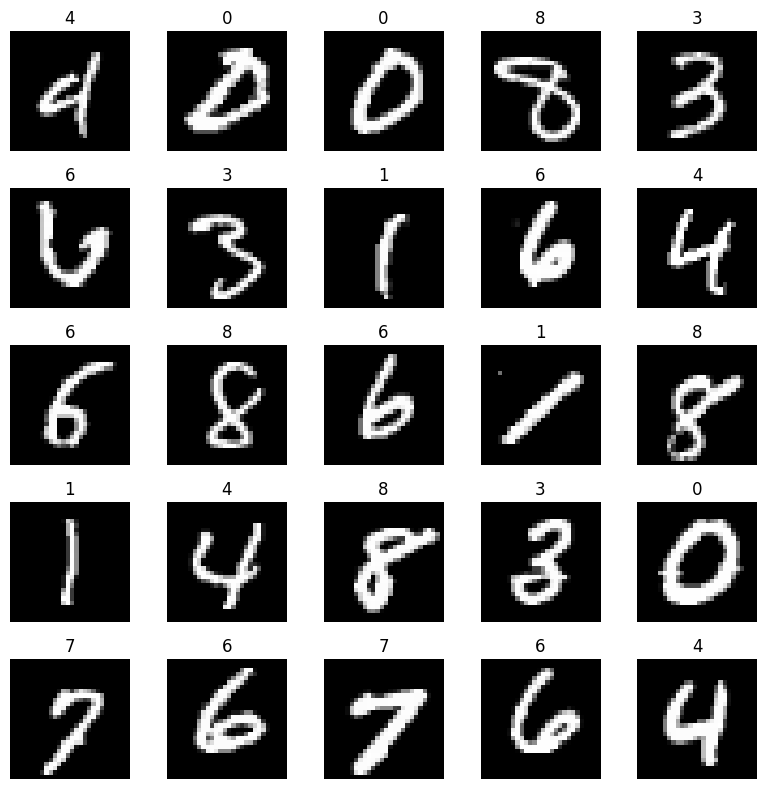

time: 4.79 s (started: 2024-07-01 01:34:26 +00:00)


In [ ]:
# sample 25개를 그리기
fig = plt.figure(figsize = (8, 8))
for i, idx in enumerate(sample):
    plt.subplot(5, 5, i+1) # 5*5, 1번부터
    plt.imshow(X_train[idx], cmap = 'gray') # color map
    plt.axis('off') # 축을 지움
    plt.title(y_train[idx]) # 정답값
fig.tight_layout() # 보기 좋게 변경
plt.show()

In [ ]:
# y값 balance 보기
# value_counts는 pandas 기능
# 인덱스 단위로 sort : sort_index()
sr = pd.Series(y_train).value_counts().sort_index()

time: 21.3 ms (started: 2024-07-01 01:34:31 +00:00)


<BarContainer object of 10 artists>

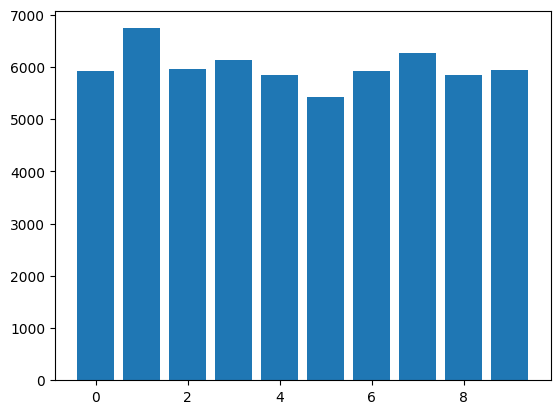

time: 1.46 s (started: 2024-07-01 01:34:31 +00:00)


In [ ]:
# 막대그래프로 그리기
plt.bar(sr.index, sr)

## 3. 학습용, 검증용 데이터 분리

In [ ]:
# sklearn : train_test_split 사용
# shuffle 사용 - 데이터를 섞음
from sklearn.model_selection import train_test_split
# 훈련용 데이터, 정답은 항상 같이 움지여야 함으로 같이 넣어줘야 함
# shuffle = True은 default
# 받는 순서를 잘 지켜야 함
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
# shape을 계속 확인하는 습관 필요
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(48000, 28, 28) (12000, 28, 28)
(48000,) (12000,)
time: 665 ms (started: 2024-07-01 01:34:33 +00:00)


## 4. 전처리
* X값은 스케일링
* y값은 one-hot encoding

In [ ]:
# X 값 처리
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,  17,  47,  47,  47,  47,  47,  47,
         28,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  14,  63,   0,   0,
          0,  62, 138, 197, 197, 197, 217, 253, 253, 253, 253, 253, 253,
        230,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 151, 170,   0,  56,
        232, 250, 253, 231, 217, 217, 217, 217, 217, 217, 217, 128, 179,
        132,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 104, 251, 170,  20, 233,
        253, 199,  84,  26,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   5, 203, 253, 160,   3,  20,
         20,   7,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  77, 253, 228,  21,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 150, 253, 249, 223, 223, 193,
         71,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 126, 253, 253, 253, 253, 253,
        253, 196, 121,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   8, 202, 191, 144, 144, 217,
        251, 253, 253, 170,   4,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         53, 236, 253, 253, 215,   3,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  34, 180, 253, 253, 128,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   2, 140, 253, 236,  36,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  37,   0,   0,   0,   0,   0,
          0,   0,   0,  13, 215, 253,  62,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 246,  53,   0,   0,   0,   0,
          0,   0,   0,   0, 105, 253,  62,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 254,  57,   0,   0,   0,   0,
          0,   0,   0,   0,  99, 253,  62,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 255,  65,   0,   0,   0,   0,
          0,   0,   0,  35, 217, 253,  62,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 227, 223, 115,  18,   0,   0,
          5,  68, 113, 222, 253, 242,  46,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  41, 224, 253, 227, 218, 218,
        220, 253, 253, 253, 249,  76,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  35, 150, 215, 253, 253,
        253, 253, 205, 175,  57,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   

time: 63.3 ms (started: 2024-07-01 01:34:33 +00:00)


In [ ]:
# 0 ~ 255 사이의 값 - 스케일링 할 때, 0~1사이 값으로 변형하는 것이 목적
# sklearn에 있는 MinMaxScaler 사용
# MinMaxScaler는 사실 이미지에 사용하는 것은 아님, 굳이 minmaxscaler를 사용하지 않아도 됨
# (X-0) / (255 - 0) = X / 255하면 MinMaxScaler가 끝남
X_train_s = X_train / 255.
X_val_s = X_val / 255.

time: 350 ms (started: 2024-07-01 01:34:34 +00:00)


In [ ]:
X_train_s[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

time: 24.6 ms (started: 2024-07-01 01:34:34 +00:00)


In [ ]:
# y 값 one-hot encoding
# sklearn에 OneHotEncoder가 있음
# keras에도 존재함
from keras.utils import to_categorical

y_train_o = to_categorical(y_train)
y_val_o = to_categorical(y_val)

time: 7.58 ms (started: 2024-07-01 01:34:34 +00:00)


In [ ]:
y_train_o.shape, y_val_o.shape

((48000, 10), (12000, 10))

time: 11.8 ms (started: 2024-07-01 01:34:34 +00:00)


In [ ]:
y_train_o[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

time: 5.34 ms (started: 2024-07-01 01:34:34 +00:00)


In [ ]:
print(X_train_s.shape, X_val_s.shape)
print(y_train_o.shape, y_val_o.shape)
print(type(X_train_s), type(X_val_s))
print(type(y_train_o), type(y_val_o))

(48000, 28, 28) (12000, 28, 28)
(48000, 10) (12000, 10)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
time: 1.02 ms (started: 2024-07-01 01:34:34 +00:00)


## 5. 모델 생성

In [ ]:
# 컬러면 3차원이어서 *3이 더 들어감
# 이미지가 가지고 있는 특징이 사라짐?? 섞이는 것이 맞고 이미지 특징이 사라져서 이를 방지하기 위해 CNN을 진행
X_train_s = X_train_s.reshape(-1, 28*28)
X_val_s = X_val_s.reshape(-1, 28*28)
print(X_train_s.shape, X_val_s.shape)

(48000, 784) (12000, 784)
time: 1.59 ms (started: 2024-07-01 01:34:34 +00:00)


In [ ]:
from keras import layers

model = keras.Sequential([
    layers.Dense(64, activation = 'relu', input_shape=(784,)), # Dense는 2차원 데이터를 받을 수 없음
    layers.Dense(32, activation = 'relu'),
    layers.Dense(16, activation = 'relu'),
    layers.Dense(10, activation = 'softmax')
])

time: 570 ms (started: 2024-07-01 01:34:34 +00:00)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 10)                170       
                                                                 
Total params: 53018 (207.10 KB)
Trainable params: 53018 (207.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
time: 133 ms (started: 2024-07-01 01:34:35 +00:00)


In [ ]:
# https://keras.io/api/optimizers/adam/
# 다음과 같이 내부가 형성됨
# lr = 0.001임 -> 이를 바꿔서 사용하고 싶으면, 문자열로 적지 말고 객체로 만들어서 넣어야함
adam = keras.optimizers.Adam(
    learning_rate=0.01
)

model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

time: 64.3 ms (started: 2024-07-01 01:34:35 +00:00)


In [ ]:
EPOCHS = 10
BATCH_SIZE = 32 # 48000 / 32 batch_size = 1500step * 30 epochs 학습 진행
# val_loss가 작은 값을 선택하는 것이 가장 좋

history = model.fit(X_train_s, y_train_o,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data = (X_val_s, y_val_o))

Epoch 1/10
1500/1500 [==============================] - 18s 10ms/step - loss: 0.3103 - accuracy: 0.9071 - val_loss: 0.1888 - val_accuracy: 0.9479
Epoch 2/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.1885 - accuracy: 0.9474 - val_loss: 0.1885 - val_accuracy: 0.9495
Epoch 3/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.1599 - accuracy: 0.9557 - val_loss: 0.1762 - val_accuracy: 0.9559
Epoch 4/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1477 - accuracy: 0.9615 - val_loss: 0.1571 - val_accuracy: 0.9569
Epoch 5/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.1389 - accuracy: 0.9632 - val_loss: 0.1869 - val_accuracy: 0.9552
Epoch 6/10
1500/1500 [==============================] - 16s 11ms/step - loss: 0.1293 - accuracy: 0.9660 - val_loss: 0.1963 - val_accuracy: 0.9534
Epoch 7/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.1250 - accuracy: 0.9685 - val_loss: 0.1646 - val_

In [ ]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'], label='train loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='val loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['accuracy'], label='train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'], label='val accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.show()

time: 926 µs (started: 2024-07-01 01:37:01 +00:00)


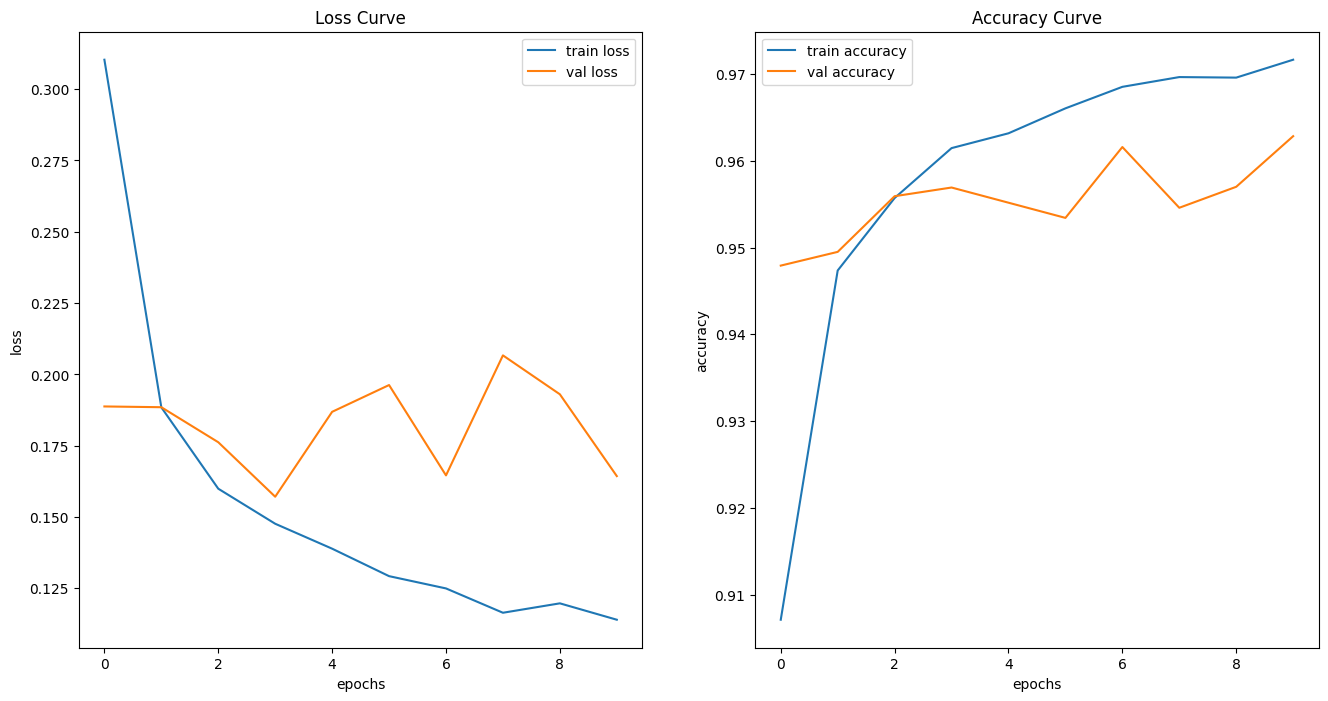

time: 536 ms (started: 2024-07-01 01:37:01 +00:00)


In [ ]:
plot_history(history)

## 6. 평가

In [ ]:
X_test_s = X_test / 255.
X_test_s = X_test_s.reshape(-1, 28*28)
y_test_o = to_categorical(y_test)
print(X_test_s.shape, y_test_o.shape)

(10000, 784) (10000, 10)
time: 80.7 ms (started: 2024-07-01 01:37:18 +00:00)


In [ ]:
y_pred = model.predict(X_test_s)

y_pred[:10]

313/313 [==============================] - 2s 4ms/step


array([[1.1406711e-06, 5.8743343e-08, 8.2961918e-07, 5.2451155e-06,
        1.7003973e-08, 4.1095261e-09, 1.1937880e-14, 9.9999171e-01,
        9.1701562e-09, 8.5295869e-07],
       [1.4578673e-11, 8.2964544e-07, 9.9889100e-01, 1.0530261e-03,
        8.4482066e-10, 2.9227350e-11, 9.8714907e-14, 5.4670436e-05,
        5.1019566e-07, 1.9413407e-10],
       [4.4225761e-25, 9.9999112e-01, 2.0594318e-07, 3.3799763e-09,
        7.5133944e-09, 3.3933360e-12, 3.1087987e-07, 7.2979711e-09,
        8.3411896e-06, 5.1268755e-13],
       [9.9996787e-01, 6.6131212e-11, 1.5927262e-05, 1.2236710e-05,
        3.7135575e-09, 4.9474852e-07, 6.9210739e-07, 3.3910474e-10,
        2.7203025e-06, 4.6900560e-08],
       [4.2561288e-15, 1.9103084e-10, 3.9284703e-10, 2.5012970e-21,
        9.9999958e-01, 1.3740727e-15, 4.3022070e-09, 3.0936465e-07,
        3.4064065e-15, 7.9515916e-10],
       [1.6328627e-35, 9.9999994e-01, 2.4048000e-10, 6.8625802e-13,
        1.7826308e-12, 3.1977022e-17, 5.5962140e-10, 1.83

time: 3.28 s (started: 2024-07-01 01:37:19 +00:00)


In [ ]:
# y_pred argmax 처리
y_pred = np.argmax(y_pred, axis = 1)
y_pred

array([7, 2, 1, ..., 4, 5, 6])

time: 5.09 ms (started: 2024-07-01 01:37:26 +00:00)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
def print_metrics(y_true, y_pred, aver='macro'):
    print("accuracy:", accuracy_score(y_true, y_pred))
    print("recall_score:", recall_score(y_true, y_pred, average = aver))
    print("precision_score:", precision_score(y_true, y_pred, average = aver))
    print("f1_score:", f1_score(y_true, y_pred, average = aver))
    cfm = confusion_matrix(y_true, y_pred)
    s = sns.heatmap(cfm, annot=True, cmap='Blues', fmt = 'd', cbar=False)
    s.set(xlabel='Prediction', ylabel='Actual')
    plt.show()

time: 844 µs (started: 2024-07-01 01:37:28 +00:00)


accuracy: 0.9654
recall_score: 0.9648194607731628
precision_score: 0.9653315864327787
f1_score: 0.9649207025562537


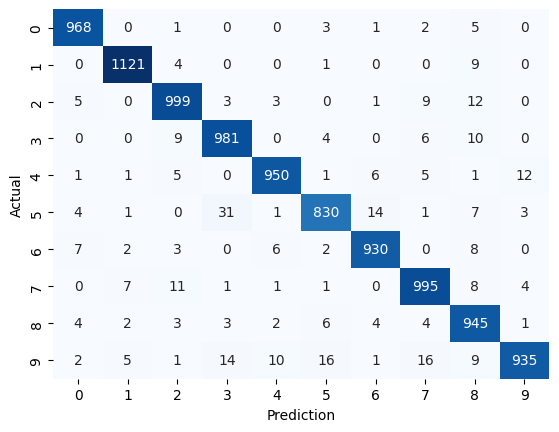

time: 1.31 s (started: 2024-07-01 01:37:44 +00:00)


In [ ]:
print_metrics(y_test, y_pred, aver='macro')

In [ ]:
# test 데이터 중에 다음과 같이 뽑음
sample = np.random.randint(10000, size = 25)
sample

array([4555, 3385, 6396, 8666, 9274, 2558, 7849, 2047, 2747, 9167, 9998,
        189, 2734, 3005, 4658, 1899, 7734, 1267, 1528, 3556, 3890, 8838,
       5393, 8792, 8433])

time: 13.3 ms (started: 2024-07-01 01:39:15 +00:00)


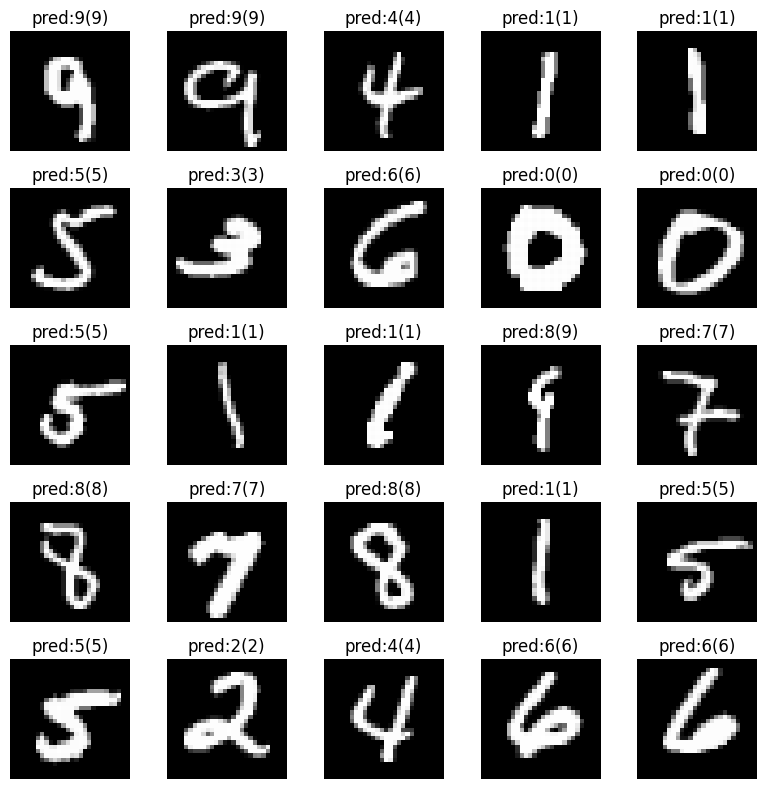

time: 4.33 s (started: 2024-07-01 01:40:53 +00:00)


In [ ]:
fig = plt.figure(figsize = (8, 8))
for i, idx in enumerate(sample):
    plt.subplot(5, 5, i+1) # 5*5, 1번부터
    plt.imshow(X_test[idx], cmap = 'gray') # color map
    plt.axis('off') # 축을 지움
    plt.title(f'pred:{y_pred[idx]}({y_test[idx]})') # 정답값
fig.tight_layout() # 보기 좋게 변경
plt.show()

In [ ]:
# 틀린 값만 뽑기
wrong_data = np.where(y_test != y_pred)[0]
pd.Series(wrong_data).value_counts().sum()

346

time: 10.4 ms (started: 2024-07-01 01:43:24 +00:00)


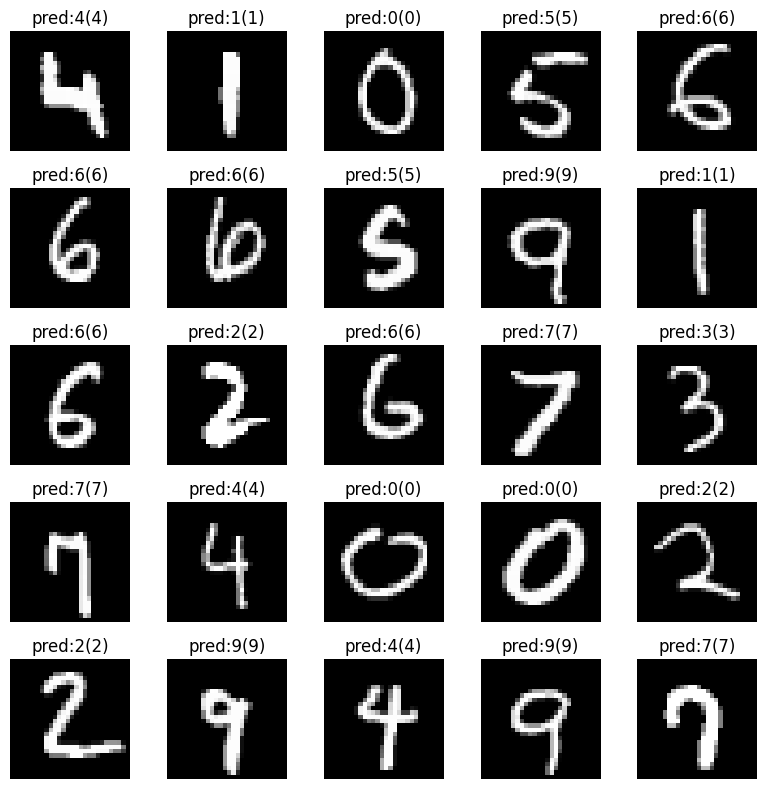

time: 3.34 s (started: 2024-07-01 05:13:56 +00:00)


In [44]:
wrong_data = np.random.randint(980, size = 25)

fig = plt.figure(figsize = (8, 8))
for i, idx in enumerate(wrong_data):
    plt.subplot(5, 5, i+1) # 5*5, 1번부터
    plt.imshow(X_test[idx], cmap = 'gray') # color map
    plt.axis('off') # 축을 지움
    plt.title(f'pred:{y_pred[idx]}({y_test[idx]})') # 정답값
fig.tight_layout() # 보기 좋게 변경
plt.show()